In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from comparers import ModelComparer
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


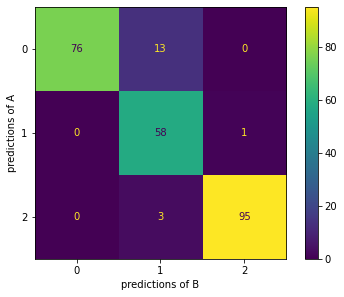

In [4]:
comparer.plot_confusion_matrix(X)
plt.savefig('boston-cf.pdf')

# Ground Truth

In [6]:
%%time
for label in comparer.difference_class_names:
    print(label)
    ground_truth_instance_indices, ground_truth = calc_ground_truth_constraints(comparer, feature_precisions, X, label)
    with open(f'ground_truth.{label}.pickle', 'wb') as f:
        pickle.dump((ground_truth_instance_indices, ground_truth), f)
    rules = constraint_matrix_to_rules(ground_truth, feature_names, precisions=feature_precisions, latex=True)
    for instance_idx, rule in zip(ground_truth_instance_indices, rules):
        print(f'\item {instance_idx}: ${rule}$')
    print()

(0, 1)
\item 8: $3 < \mathit{CRIM} \leq 6 \land \mathit{ZN} \leq 0 \land \mathit{INDUS} > 16.87 \land \mathit{RM} \leq 6.73 \land \mathit{AGE} > 1 \land \mathit{DIS} \leq 4.72 \land \mathit{RAD} > 21.40 \land \mathit{TAX} > 499 \land 16.71 < \mathit{PTRATIO} \leq 20.73 \land 13.90 < \mathit{LSTAT} \leq 16.12$
\item 28: $0 < \mathit{CRIM} \leq 3 \land \mathit{ZN} \leq 3 \land \mathit{INDUS} > 13.87 \land \mathit{RM} \leq 8.07 \land \mathit{AGE} > 1 \land \mathit{RAD} \leq 16.77 \land 287 < \mathit{TAX} \leq 508 \land \mathit{PTRATIO} \leq 17.14 \land 10.29 < \mathit{LSTAT} \leq 12.93$
\item 40: $1 < \mathit{CRIM} \leq 4 \land \mathit{ZN} \leq 1 \land \mathit{INDUS} > 16.97 \land \mathit{RM} \leq 7.33 \land \mathit{AGE} > 0 \land \mathit{DIS} \leq 6.59 \land \mathit{RAD} \leq 23.90 \land 222 < \mathit{TAX} \leq 451 \land \mathit{PTRATIO} \leq 15.83 \land 10.48 < \mathit{LSTAT} \leq 13.13$
\item 42: $\mathit{CRIM} \leq 1 \land \mathit{ZN} \leq 4 \land \mathit{INDUS} \leq 10.63 \land \math

# Results

In [47]:
with open('results.baseline.pickle', 'rb') as f:
    global_fidelity_baseline, local_fidelity_baseline, complexity_baseline = pickle.load(f)
with open('results.soa.pickle', 'rb') as f:
    global_fidelity_soa, local_fidelity_soa, complexity_soa = pickle.load(f)
with open('results.proposed.pickle', 'rb') as f:
    global_fidelity_proposed, local_fidelity_proposed, complexity_proposed = pickle.load(f)

In [48]:
global_fidelity = pd.concat([global_fidelity_baseline, global_fidelity_soa, global_fidelity_proposed],
                            keys=['BA', 'SOA', 'PA'], names=['approach'])
global_fidelity = global_fidelity.reorder_levels(['class', 'level', 'approach']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class  level  approach                                        
(0, 1) global BA         1.000000  1.000000  1.000000       13
              PA         0.200000  1.000000  0.333333       13
              SOA        0.127660  0.923077  0.224299       13
       local  PA         0.565217  1.000000  0.722222       13
              SOA        0.266667  0.923077  0.413793       13
(1, 2) global BA         1.000000  1.000000  1.000000        1
              PA         1.000000  1.000000  1.000000        1
              SOA        0.022727  1.000000  0.044444        1
(2, 1) global BA         1.000000  1.000000  1.000000        3
              PA         0.187500  1.000000  0.315789        3
              SOA        0.051282  0.666667  0.095238        3

In [49]:
print(global_fidelity.to_latex(float_format=lambda x: '{:.2f}'.format(x)))

\begin{tabular}{lllrrrr}
\toprule
       &        &     &  Precision &  Recall &  F1 Score &  Support \\
class & level & approach &            &         &           &          \\
\midrule
(0, 1) & global & BA &       1.00 &    1.00 &      1.00 &       13 \\
       &        & PA &       0.20 &    1.00 &      0.33 &       13 \\
       &        & SOA &       0.13 &    0.92 &      0.22 &       13 \\
       & local & PA &       0.57 &    1.00 &      0.72 &       13 \\
       &        & SOA &       0.27 &    0.92 &      0.41 &       13 \\
(1, 2) & global & BA &       1.00 &    1.00 &      1.00 &        1 \\
       &        & PA &       1.00 &    1.00 &      1.00 &        1 \\
       &        & SOA &       0.02 &    1.00 &      0.04 &        1 \\
(2, 1) & global & BA &       1.00 &    1.00 &      1.00 &        3 \\
       &        & PA &       0.19 &    1.00 &      0.32 &        3 \\
       &        & SOA &       0.05 &    0.67 &      0.10 &        3 \\
\bottomrule
\end{tabular}



In [50]:
pd.set_option('display.max_rows', None)

In [51]:
local_fidelity = pd.concat([local_fidelity_baseline, local_fidelity_soa, local_fidelity_proposed],
                             axis=1, keys=['BA', 'SOA', 'PA'], names=['approach', 'metric'])
local_fidelity = local_fidelity.reorder_levels(['metric', 'approach'], axis=1).sort_index(axis=1)
local_fidelity

metric                 BAR                      BMR                      \
approach                BA   PA       SOA        BA        PA       SOA   
class  level  feature                                                     
(0, 1) global AGE      NaN  0.0  0.000000  1.000000  0.000000  0.000000   
              CRIM     0.0  0.0       NaN  0.631579  0.315789  1.000000   
              DIS      1.0  NaN       NaN  1.000000  1.000000  1.000000   
              INDUS    0.0  NaN       NaN  0.850000  1.000000  1.000000   
              LSTAT    0.0  0.0  0.000000  0.076923  0.000000  0.500000   
              NOX      1.0  NaN       NaN       NaN       NaN       NaN   
              PTRATIO  0.0  NaN       NaN  0.833333  1.000000  1.000000   
              RAD      NaN  NaN       NaN  1.000000  1.000000  1.000000   
              RM       NaN  NaN       NaN  1.000000  1.000000  1.000000   
              TAX      NaN  NaN       NaN  1.000000  1.000000  1.000000   
              ZN       NaN  0.0       NaN  1.000000  0.000000  1.000000   
       local  AGE      NaN  0.0  0.076923       NaN  0.000000  0.000000   
              CRIM     NaN  0.0  0.000000       NaN  0.105263  0.352941   
              DIS      NaN  0.0       NaN       NaN  0.400000  1.000000   
              INDUS    NaN  0.0  0.000000       NaN  0.200000  0.421053   
              LSTAT    NaN  0.0  0.000000       NaN  0.000000  0.000000   
              NOX      NaN  NaN  1.000000       NaN       NaN       NaN   
              PTRATIO  NaN  0.0  0.200000       NaN  0.388889  0.500000   
              RAD      NaN  0.0  0.000000       NaN  0.000000  0.400000   
              RM       NaN  0.0       NaN       NaN  0.785714  1.000000   
              TAX      NaN  0.0  0.000000       NaN  0.043478  0.500000   
              ZN       NaN  0.0  0.500000       NaN  0.000000  0.000000   
(1, 2) global AGE      NaN  0.0  0.000000  1.000000  0.000000  0.000000   
              CRIM     NaN  NaN  0.500000  1.000000  1.000000  0.000000   
              DIS      NaN  0.0       NaN  1.000000  0.000000  1.000000   
              INDUS    1.0  0.0       NaN  1.000000  0.000000  1.000000   
              LSTAT    0.0  0.0  0.000000  0.500000  0.000000  0.000000   
              NOX      NaN  NaN       NaN       NaN       NaN       NaN   
              PTRATIO  NaN  0.0       NaN  1.000000  0.000000  1.000000   
              RAD      0.0  0.0       NaN  0.500000  0.000000  1.000000   
              RM       0.0  0.0       NaN  0.500000  0.000000  1.000000   
              TAX      NaN  NaN       NaN       NaN       NaN       NaN   
              ZN       NaN  NaN  0.500000  1.000000  1.000000  0.000000   
(2, 1) global AGE      NaN  0.0  0.000000  1.000000  0.000000  0.000000   
              CRIM     NaN  NaN       NaN  1.000000  1.000000  1.000000   
              DIS      0.5  0.0       NaN  0.800000  0.400000  1.000000   
              INDUS    NaN  0.0       NaN  1.000000  0.400000  1.000000   
              LSTAT    0.0  0.0  0.000000  0.500000  0.000000  0.000000   
              NOX      1.0  NaN       NaN       NaN       NaN       NaN   
              PTRATIO  1.0  NaN       NaN  1.000000  1.000000  1.000000   
              RAD      0.0  NaN       NaN  0.500000  1.000000  1.000000   
              RM       0.0  0.0       NaN  0.400000  0.400000  1.000000   
              TAX      NaN  NaN       NaN  1.000000  1.000000  1.000000   
              ZN       NaN  NaN       NaN  1.000000  1.000000  1.000000   

metric                      RMSE                         
approach                      BA         PA         SOA  
class  level  feature                                    
(0, 1) global AGE            NaN   0.919866    0.601862  
              CRIM      0.794867   4.169486         NaN  
              DIS            NaN        NaN         NaN  
              INDUS     1.681197        NaN         NaN  
              LSTAT     1.270440   4.104498    4.180346  
          

In [52]:
df = local_fidelity[(local_fidelity.index.get_level_values('class') == '(0, 1)') & 
                    (local_fidelity.index.get_level_values('level') == 'global')]
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{llrrrrrrrrr}
\toprule
       & metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
       & approach &   BA &   PA &  SOA &   BA &   PA &  SOA &   BA &   PA &  SOA \\
class & feature &      &      &      &      &      &      &      &      &      \\
\midrule
(0, 1) & AGE &      & 0.00 & 0.00 & 1.00 & 0.00 & 0.00 &      & 0.92 & 0.60 \\
       & CRIM & 0.00 & 0.00 &      & 0.63 & 0.32 & 1.00 & 0.79 & 4.17 &      \\
       & DIS & 1.00 &      &      & 1.00 & 1.00 & 1.00 &      &      &      \\
       & INDUS & 0.00 &      &      & 0.85 & 1.00 & 1.00 & 1.68 &      &      \\
       & LSTAT & 0.00 & 0.00 & 0.00 & 0.08 & 0.00 & 0.50 & 1.27 & 4.10 & 4.18 \\
       & NOX & 1.00 &      &      &      &      &      &      &      &      \\
       & PTRATIO & 0.00 &      &      & 0.83 & 1.00 & 1.00 & 0.43 &      &      \\
       & RAD &      &      &      & 1.00 & 1.00 & 1.00 &      &      &      \\
       & RM &      &      &      & 1.00 & 1.00 &

In [53]:
df = local_fidelity[(local_fidelity.index.get_level_values('class') == '(0, 1)') & 
                    (local_fidelity.index.get_level_values('level') == 'local')]
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{llrrrrrrrrr}
\toprule
       & metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
       & approach &  BA &   PA &  SOA &  BA &   PA &  SOA &   BA &    PA &    SOA \\
class & feature &     &      &      &     &      &      &      &       &        \\
\midrule
(0, 1) & AGE &     & 0.00 & 0.08 &     & 0.00 & 0.00 &      &  0.55 &   0.63 \\
       & CRIM &     & 0.00 & 0.00 &     & 0.11 & 0.35 &      &  0.84 &   2.14 \\
       & DIS &     & 0.00 &      &     & 0.40 & 1.00 &      &  0.34 &        \\
       & INDUS &     & 0.00 & 0.00 &     & 0.20 & 0.42 &      &  2.07 &   5.24 \\
       & LSTAT &     & 0.00 & 0.00 &     & 0.00 & 0.00 &      &  1.42 &   3.13 \\
       & NOX &     &      & 1.00 &     &      &      &      &       &        \\
       & PTRATIO &     & 0.00 & 0.20 &     & 0.39 & 0.50 &      &  0.80 &   6.31 \\
       & RAD &     & 0.00 & 0.00 &     & 0.00 & 0.40 &      &  4.93 &   6.14 \\
       & RM &     & 0.00 &      &     

In [54]:
df = local_fidelity[(local_fidelity.index.get_level_values('class') == '(1, 2)') & 
                    (local_fidelity.index.get_level_values('level') == 'global')]
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{llrrrrrrrrr}
\toprule
       & metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
       & approach &   BA &   PA &  SOA &   BA &   PA &  SOA &   BA &   PA &   SOA \\
class & feature &      &      &      &      &      &      &      &      &       \\
\midrule
(1, 2) & AGE &      & 0.00 & 0.00 & 1.00 & 0.00 & 0.00 &      & 0.00 &  0.10 \\
       & CRIM &      &      & 0.50 & 1.00 & 1.00 & 0.00 &      &      &  4.31 \\
       & DIS &      & 0.00 &      & 1.00 & 0.00 & 1.00 &      & 0.00 &       \\
       & INDUS & 1.00 & 0.00 &      & 1.00 & 0.00 & 1.00 &      & 0.00 &       \\
       & LSTAT & 0.00 & 0.00 & 0.00 & 0.50 & 0.00 & 0.00 & 0.01 & 0.00 &  3.76 \\
       & NOX &      &      &      &      &      &      &      &      &       \\
       & PTRATIO &      & 0.00 &      & 1.00 & 0.00 & 1.00 &      & 0.00 &       \\
       & RAD & 0.00 & 0.00 &      & 0.50 & 0.00 & 1.00 & 6.72 & 0.00 &       \\
       & RM & 0.00 & 0.00 &      & 0.5

In [55]:
df = local_fidelity[(local_fidelity.index.get_level_values('class') == '(2, 1)') & 
                    (local_fidelity.index.get_level_values('level') == 'global')]
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{llrrrrrrrrr}
\toprule
       & metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
       & approach &   BA &   PA &  SOA &   BA &   PA &  SOA &    BA &   PA &  SOA \\
class & feature &      &      &      &      &      &      &       &      &      \\
\midrule
(2, 1) & AGE &      & 0.00 & 0.00 & 1.00 & 0.00 & 0.00 &       & 0.82 & 0.56 \\
       & CRIM &      &      &      & 1.00 & 1.00 & 1.00 &       &      &      \\
       & DIS & 0.50 & 0.00 &      & 0.80 & 0.40 & 1.00 &  1.14 & 1.16 &      \\
       & INDUS &      & 0.00 &      & 1.00 & 0.40 & 1.00 &       & 9.86 &      \\
       & LSTAT & 0.00 & 0.00 & 0.00 & 0.50 & 0.00 & 0.00 &  1.75 & 1.44 & 4.56 \\
       & NOX & 1.00 &      &      &      &      &      &       &      &      \\
       & PTRATIO & 1.00 &      &      & 1.00 & 1.00 & 1.00 &       &      &      \\
       & RAD & 0.00 &      &      & 0.50 & 1.00 & 1.00 & 11.72 &      &      \\
       & RM & 0.00 & 0.00 &      & 0.4

In [56]:
complexity = pd.concat([complexity_baseline, complexity_soa, complexity_proposed],
                       keys=['BA', 'SOA', 'PA'], names=['approach'])
complexity = complexity.reorder_levels(['class', 'level', 'approach']).sort_index()
complexity

Rules  Constraints
class  level  approach                    
(0, 1) global BA            6           27
              PA            1            5
              SOA           1            2
       local  PA            5           54
              SOA           3           27
(1, 2) global BA            1            4
              PA            1           11
              SOA           1            7
(2, 1) global BA            2            8
              PA            1            6
              SOA           1            3

In [57]:
print(complexity.to_latex())

\begin{tabular}{lllrr}
\toprule
       &        &     &  Rules &  Constraints \\
class & level & approach &        &              \\
\midrule
(0, 1) & global & BA &      6 &           27 \\
       &        & PA &      1 &            5 \\
       &        & SOA &      1 &            2 \\
       & local & PA &      5 &           54 \\
       &        & SOA &      3 &           27 \\
(1, 2) & global & BA &      1 &            4 \\
       &        & PA &      1 &           11 \\
       &        & SOA &      1 &            7 \\
(2, 1) & global & BA &      2 &            8 \\
       &        & PA &      1 &            6 \\
       &        & SOA &      1 &            3 \\
\bottomrule
\end{tabular}



In [58]:
generation_time = pd.DataFrame({
    'SOA': '47m',
    'BA': '<1s',
    'PA': '8m'}, index=['Time']).T
generation_time

,Time
SOA,47m
BA,<1s
PA,8m


In [59]:
print(generation_time.to_latex())

\begin{tabular}{ll}
\toprule
{} & Time \\
\midrule
SOA &  47m \\
BA  &  <1s \\
PA  &   8m \\
\bottomrule
\end{tabular}

